In [1]:
%%capture
pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
%%capture
pip install -U keras-core keras-cv

In [3]:
%%shell
git clone -b add-amg https://github.com/tirthasheshpatel/segment_anything_tensorflow.git
mkdir -p sam_tf
mv -f segment_anything_tensorflow/sam_tf/* sam_tf/
mv -f segment_anything_tensorflow/weights_porter.py  ./

Cloning into 'segment_anything_tensorflow'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 199 (delta 22), reused 27 (delta 21), pack-reused 166
Receiving objects: 100% (199/199), 9.30 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [4]:
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg -o dog.jpg

In [5]:
# Get the huge PyTorch model weights
!curl -sSL https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -o sam_vit_h_4b8939.pth

In [6]:
import os

os.environ['KERAS_CV_MULTI_BACKEND'] = "1"
os.environ['KERAS_BACKEND'] = "tensorflow"
# os.environ['JAX_ENABLE_X64'] = "1"

In [7]:
import sys
import json
import glob
from pprint import pprint
import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools import mask as mask_utils

# torch model
import torch
from segment_anything.build_sam import build_sam_vit_h
from segment_anything.modeling import Sam
from segment_anything import sam_model_registry, SamPredictor

# tensorflow model
import keras_core as keras
from keras_core.src import ops
from sam_tf.image_encoder import ImageEncoder
from sam_tf.prompt_encoder import PromptEncoder
from sam_tf.mask_decoder import MaskDecoder, TwoWayTransformer
from sam_tf.sam import SegmentAnythingModel
from sam_tf.automatic_mask_generator import SAMAutomaticMaskGenerator
from weights_porter import port_weights

Using TensorFlow backend


In [8]:
# Define the huge model in TensorFlow

image_encoder = ImageEncoder(
    img_size=1024,
    patch_size=16,
    in_chans=3,
    embed_dim=1280,
    depth=32,
    mlp_dim=1280*4,
    num_heads=16,
    out_chans=256,
    use_bias=True,
    use_rel_pos=True,
    window_size=14,
    global_attention_indices=[7, 15, 23, 31]
)

prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(1024, 1024),
    mask_in_chans=16
)

mask_decoder = MaskDecoder(
    transformer_dim=256,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8
    ),
    num_multimask_outputs=3,
    iou_head_depth=3,
    iou_head_hidden_dim=256
)

In [9]:
# Forward Pass to build the model

x = ops.ones((1, 1024, 1024, 3))
x_embeddings = image_encoder(x)

points = ops.convert_to_tensor(
    np.random.randint(0, 1023, (7, 10, 2)),
    dtype="float32"
)
labels = ops.convert_to_tensor(
    1 * (np.random.rand(7, 10) > 0.5),
    dtype="int64"
)
box = ops.array(
    [[[[10, 10], [500, 500]],
      [[20, 20], [500, 500]],
      [[30, 30], [500, 500]],
      [[40, 40], [500, 500]],
      [[50, 50], [500, 500]],
      [[60, 60], [500, 500]],
      [[70, 70], [500, 500]]]],
    dtype="float32"
)
mask = ops.convert_to_tensor(
    1. * (np.random.rand(7, 256, 256, 1) > 0.5),
    dtype="float32"
)

sparse_embeddings, dense_embeddings = prompt_encoder(
    points=points,
    labels=labels,
    box=box,
    mask=mask
)

masks_pred, iou_pred = mask_decoder(
    image_embeddings=x_embeddings,
    image_pe=prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings[:1, ...],
    dense_prompt_embeddings=dense_embeddings[:1, ...],
    multimask_output=True
)

In [10]:
model = SegmentAnythingModel(image_encoder, prompt_encoder, mask_decoder)

In [11]:
# We create a predictor to port the weights from PyTorch to TensorFlow

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to("cuda")

predictor = SamPredictor(sam)

In [12]:
# Port the PyTorch model's weights to the multi-backend Keras model
port_weights(model, predictor.model)

In [13]:
image = cv2.imread('dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

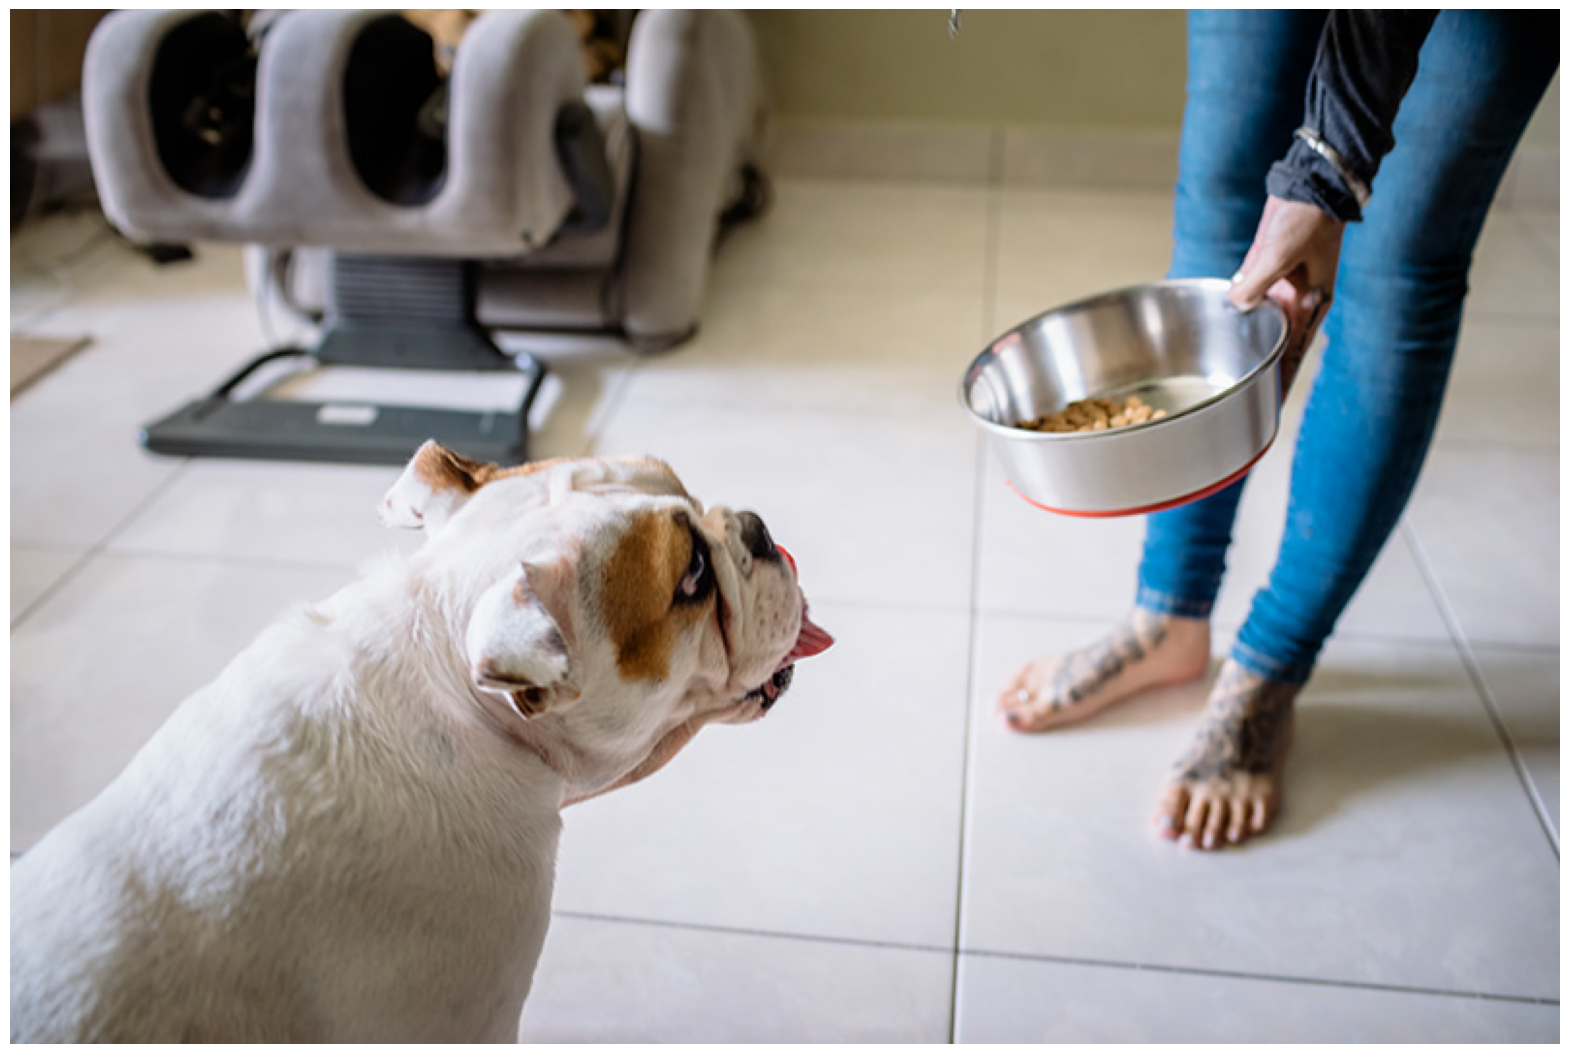

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
mask_generator = SAMAutomaticMaskGenerator(model)

In [16]:
masks = mask_generator.generate(image)

In [17]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [18]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

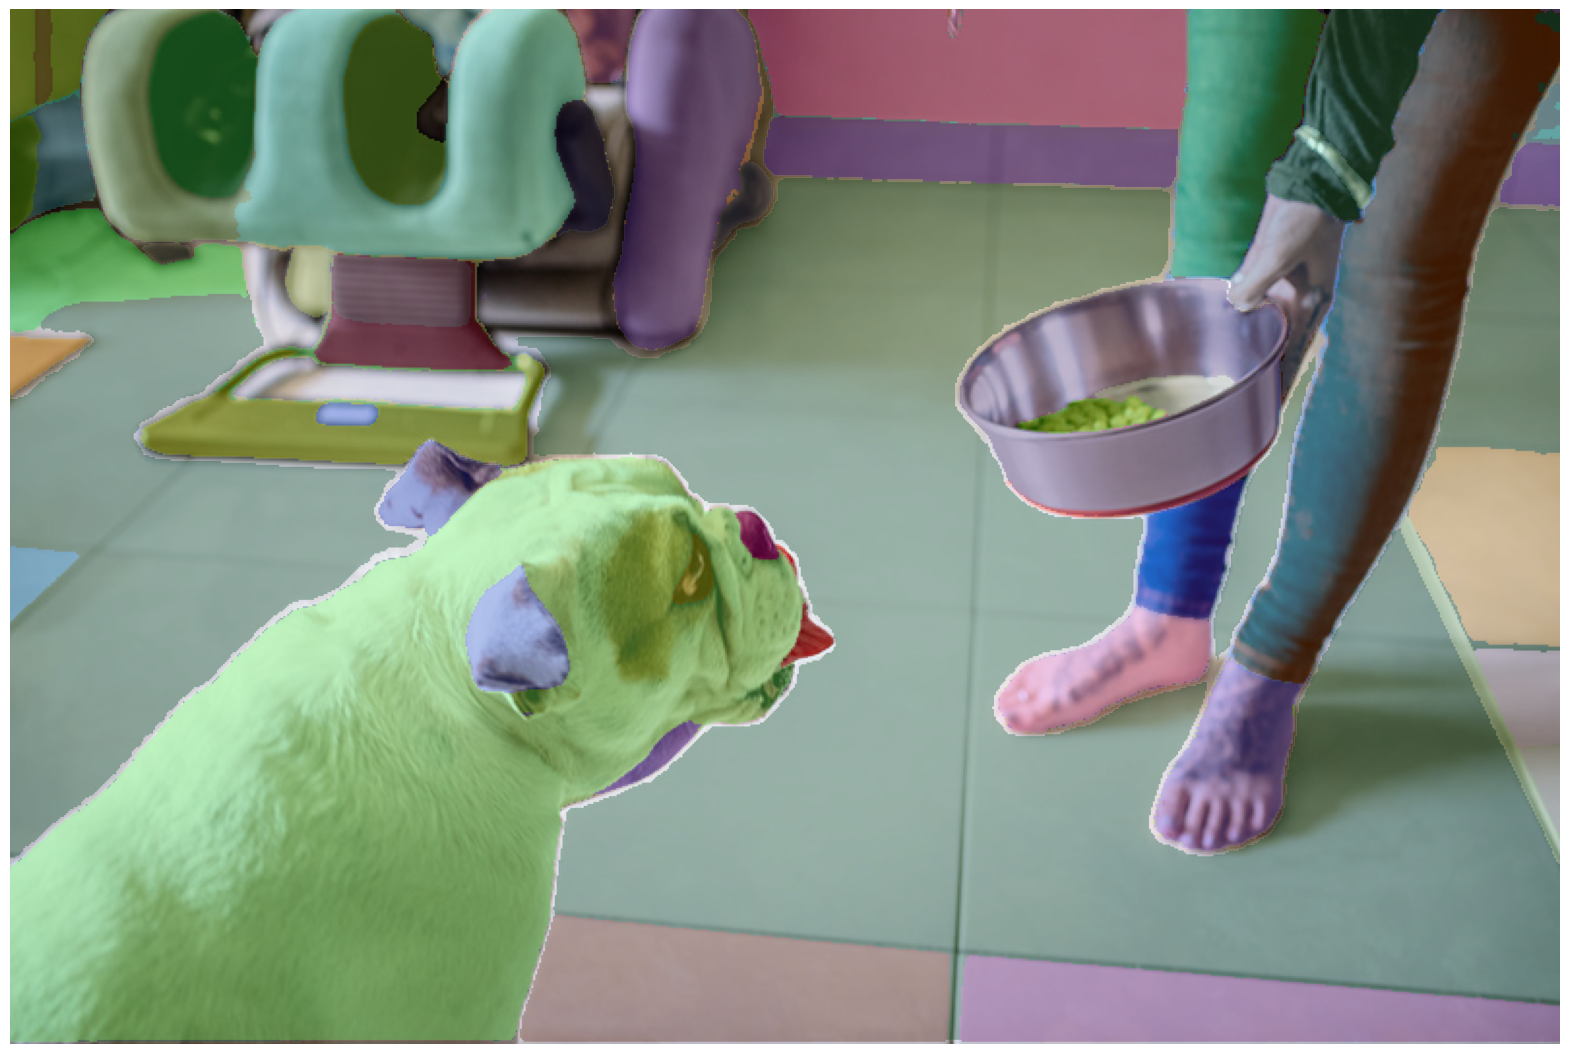

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()